### Load dataset

In [1]:
import os
import numpy as np
import scipy.io
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import os


### let's load annotation and sample image data

Displaying image: ../data/cars_train/cars_train\00001.jpg


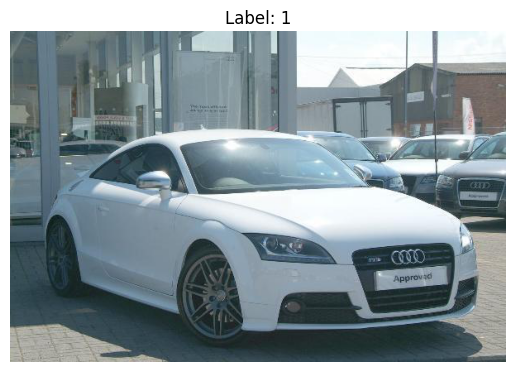

Displaying image: ../data/cars_train/cars_train\00002.jpg


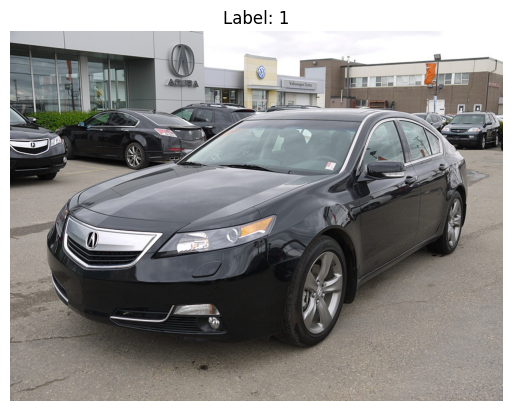

In [2]:
# Load annotations
annotations = scipy.io.loadmat('../data/cars_annos.mat')
train_images_dir = '../data/cars_train/cars_train'  # Correct base directory

# Function to display images
def show_image(image_path, label):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Display the first 2 images
for i in range(2):
    anno = annotations['annotations'][0][i]
    img_name = anno[0][0]  # Get the image name with the directory
    img_name = img_name.replace('car_ims/', '')  # Remove 'car_ims/' from the path

    # Remove leading zero if present
    if img_name.startswith('0'):
        img_name = img_name[1:]

    full_img_path = os.path.join(train_images_dir, img_name)
    label = anno[5][0][0]
    print(f"Displaying image: {full_img_path}")
    show_image(full_img_path, label)


## Filter the annotation

In [3]:
def check_max(path):

    # Load annotations
    annotations = scipy.io.loadmat(path)

    # Function to display images
    def show_image(image_path, label):
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

    # Initialize the max image number
    max_img_number = -1

    # Iterate through all annotations to find the max image name
    for anno in annotations['annotations'][0]:
        img_name = anno[0][0]  # Get the image name with the directory
        img_name_cleaned = img_name.replace('car_ims/', '')  # Remove 'car_ims/' from the path

        # Extract the numerical part of the image name
        img_number = int(img_name_cleaned.split('.')[0])
        
        # Compare and update the max image number
        if img_number > max_img_number:
            max_img_number = img_number

    # Format the max image number with leading zeros
    max_img_name = f"{max_img_number:05d}.jpg"

    print(f"The maximum image name is: {max_img_name}")

In [4]:
check_max('../data/cars_annos.mat')

The maximum image name is: 16185.jpg


since the max range is 16185 , and our train data does not contain that much image , let's remove them

In [5]:
# Load annotations
annotations = scipy.io.loadmat('../data/cars_annos.mat')
train_images_dir = '../data/cars_train/cars_train'  # Correct base directory

# Function to display images
def show_image(image_path, label):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Define the maximum allowed image number
max_allowed_img_number = 8144

# Initialize list to hold updated annotations
updated_annotations = []

# Iterate through all annotations and filter out those with image names greater than max_allowed_img_number
for anno in annotations['annotations'][0]:
    img_name = anno[0][0]  # Get the image name with the directory
    img_name_cleaned = img_name.replace('car_ims/', '')  # Remove 'car_ims/' from the path
    
    # Extract the numerical part of the image name
    img_number = int(img_name_cleaned.split('.')[0])
    
    if img_number <= max_allowed_img_number:
        updated_annotations.append(anno)

# Convert the updated annotations back to a structured array
annotations['annotations'] = np.array(updated_annotations, dtype=annotations['annotations'].dtype)

# Save the updated annotations to a new mat file
scipy.io.savemat('../data/cars_annos_updated.mat', annotations)

# Display a message indicating the number of remaining images
print(f"Updated annotations to contain only images with names less than or equal to {max_allowed_img_number:05d}.jpg.")
print(f"Total images after update: {len(updated_annotations)}")


Updated annotations to contain only images with names less than or equal to 08144.jpg.
Total images after update: 8144


In [6]:
check_max('../data/cars_annos_updated.mat')

The maximum image name is: 08144.jpg


## Prepare the dataset

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))


True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
import scipy.io
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load updated annotations
annotations = scipy.io.loadmat('../data/cars_annos_updated.mat')

# Custom dataset class
class CarDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations['annotations'][0]
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        img_name = anno[0][0].replace('car_ims/', '')

        # Remove the leading zero if present
        if img_name.startswith('0'):
            img_name = img_name[1:]

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(anno[5][0][0] - 1, dtype=torch.long)  # Get the class label and convert to LongTensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
img_dir = '../data/cars_train/cars_train'
dataset = CarDataset(annotations, img_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Using device: cuda


## NN Architecture

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the model
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = len(scipy.io.loadmat('../data/cars_annos_updated.mat')['class_names'][0])
model = VehicleClassifier(num_classes).to(device)  # Move model to the device

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Training the model

In [6]:
import time

# Training loop with timing and early stopping
num_epochs = 50
patience = 10  # Number of epochs with no improvement after which training will be stopped
best_val_loss = float('inf')
epochs_no_improve = 0

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break

# Save the final model
torch.save(model.state_dict(), 'final_model.pth')
print("Saved final model")

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time / 60:.2f} minutes')

Epoch 1/10, Loss: 4.7928
Validation Loss: 4.6435, Validation Accuracy: 0.0068
Saved best model
Epoch 2/10, Loss: 4.6412
Validation Loss: 4.6409, Validation Accuracy: 0.0098
Saved best model
Epoch 3/10, Loss: 4.6272
Validation Loss: 4.6284, Validation Accuracy: 0.0110
Saved best model
Epoch 4/10, Loss: 4.5983
Validation Loss: 4.6490, Validation Accuracy: 0.0092
Epoch 5/10, Loss: 4.4804
Validation Loss: 4.6818, Validation Accuracy: 0.0086
Early stopping triggered
Saved final model
Total training time: 7.37 minutes


## Inference

Using device: cuda
Predicted Class Counts:
Audi V8 Sedan 1994: 1154
Chevrolet Silverado 1500 Hybrid Crew Cab 2012: 279
Bentley Continental Flying Spur Sedan 2007: 159
Audi S6 Sedan 2011: 98
Chevrolet Monte Carlo Coupe 2007: 17
BMW 3 Series Sedan 2012: 1
Acura Integra Type R 2001: 5
                                 Predicted Class  Count
0                             Audi V8 Sedan 1994   1154
1  Chevrolet Silverado 1500 Hybrid Crew Cab 2012    279
2     Bentley Continental Flying Spur Sedan 2007    159
3                             Audi S6 Sedan 2011     98
4               Chevrolet Monte Carlo Coupe 2007     17
5                      Acura Integra Type R 2001      5
6                        BMW 3 Series Sedan 2012      1


<Figure size 1000x600 with 0 Axes>

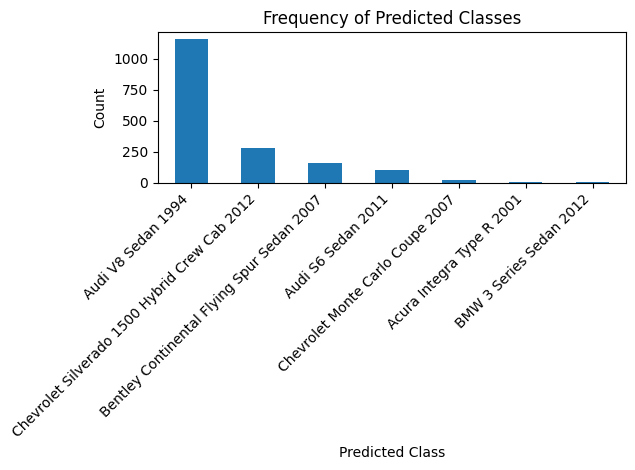

In [23]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import scipy.io
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load class names
class_names = scipy.io.loadmat('../data/cars_annos_updated.mat')['class_names'][0]

# Define the model class
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to load the model
def load_model(model_path, model_class, num_classes):
    model = model_class(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# Load the best model for inference
num_classes = len(class_names)
model = load_model('../model/final_model_epoch10_patience_2.pth', VehicleClassifier, num_classes)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict class of an image
def predict_image_class(image, model, transform):
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image = transform(image).unsqueeze(0).to(device)  # Move image to the device
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Load video
video_path = '../data/traffic.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

predicted_classes = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Predict the class of the frame
    predicted_class = predict_image_class(frame, model, transform)
    class_label = class_names[predicted_class][0]
    
    # Append to predicted_classes
    predicted_classes.append(class_label)
    
    # Display the resulting frame
    cv2.putText(frame, f'{class_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.imshow('Frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Textual representation
class_counts = defaultdict(int)
for predicted_class in predicted_classes:
    class_counts[predicted_class] += 1

print("Predicted Class Counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Tabular representation
df = pd.DataFrame(predicted_classes, columns=["Predicted Class"])
class_counts_df = df["Predicted Class"].value_counts().reset_index()
class_counts_df.columns = ["Predicted Class", "Count"]
print(class_counts_df)

# Graphical representation
plt.figure(figsize=(10, 6))
class_counts_df.plot(kind='bar', x='Predicted Class', y='Count', legend=False)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Frequency of Predicted Classes')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


lets save the results to a csv file

Using device: cuda


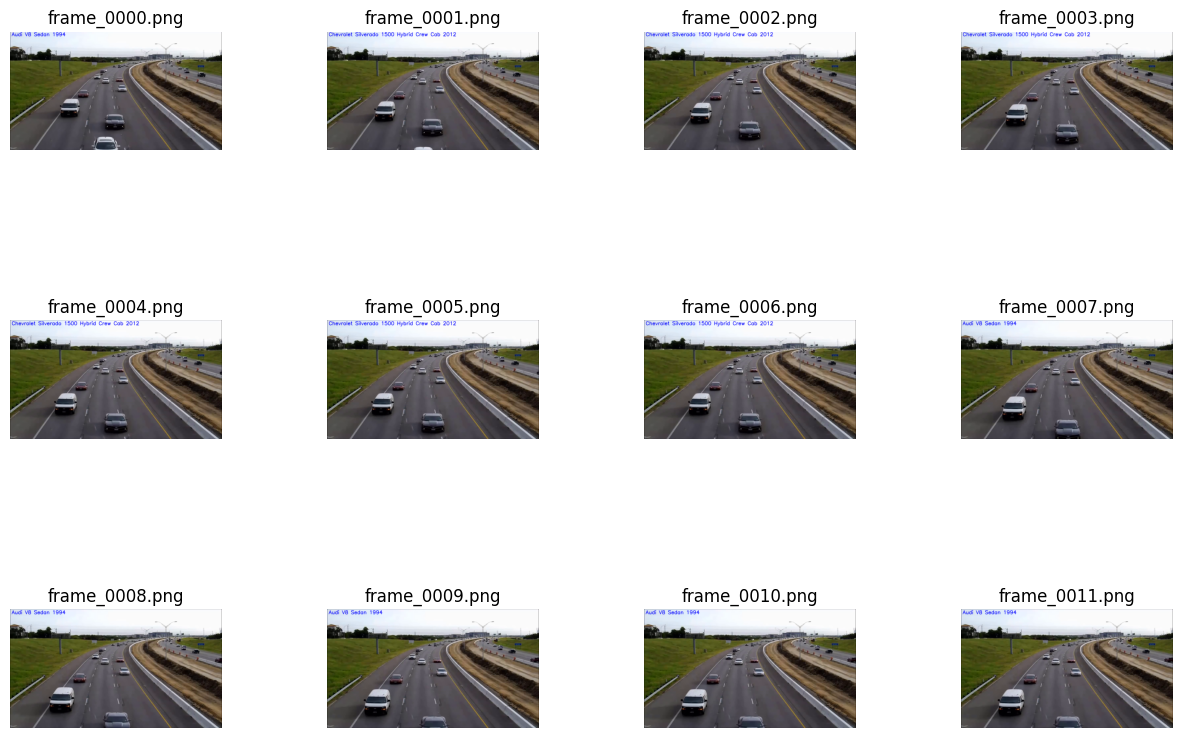

In [26]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import scipy.io
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load class names
class_names = scipy.io.loadmat('../data/cars_annos_updated.mat')['class_names'][0]

# Define the model class
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to load the model
def load_model(model_path, model_class, num_classes):
    model = model_class(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# Load the best model for inference
num_classes = len(class_names)
model = load_model('../model/final_model_epoch10_patience_2.pth', VehicleClassifier, num_classes)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict class of an image
def predict_image_class(image, model, transform):
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image = transform(image).unsqueeze(0).to(device)  # Move image to the device
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Load video
video_path = '../data/traffic.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

frame_predictions = []
frame_number = 0
output_dir = 'output_frames'
os.makedirs(output_dir, exist_ok=True)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Predict the class of the frame
    predicted_class = predict_image_class(frame, model, transform)
    class_label = class_names[predicted_class][0]
    
    # Append frame number and prediction to list
    frame_predictions.append((frame_number, class_label))
    
    # Overlay the class label on the frame
    cv2.putText(frame, f'{class_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Save the frame with the prediction
    output_path = os.path.join(output_dir, f'frame_{frame_number:04d}.png')
    cv2.imwrite(output_path, frame)
    
    frame_number += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Create DataFrame
df = pd.DataFrame(frame_predictions, columns=["Frame Number", "Predicted Class"])

# Save the DataFrame to a CSV file
df.to_csv("frame_predictions.csv", index=False)

# Display the saved frames in a grid
def display_frames_grid(output_dir, num_frames=12):
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    frame_files = sorted(os.listdir(output_dir))[:num_frames]
    for ax, frame_file in zip(axes.flatten(), frame_files):
        img = cv2.imread(os.path.join(output_dir, frame_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(frame_file)
        ax.axis('off')

    plt.show()

display_frames_grid(output_dir, num_frames=12)

## Let's try to label the dataset with color

In [ ]:
import os
import cv2
import json

# Path to the dataset
dataset_path = '../data/cars_train'
image_folder = os.path.join(dataset_path, 'cars_train')
label_file = os.path.join(dataset_path, 'color_labels.json')

# Load existing labels if available
if os.path.exists(label_file):
    with open(label_file, 'r') as f:
        color_labels = json.load(f)
else:
    color_labels = {}

# Color options
color_options = ['red', 'blue', 'green', 'black', 'white', 'yellow', 'gray', 'other']

def label_image(image_path):
    image = cv2.imread(image_path)
    cv2.imshow('Image', image)
    print(f"Label the color for the image: {image_path}")
    for i, color in enumerate(color_options):
        print(f"{i}: {color}")
    
    key = cv2.waitKey(0)
    if key >= 48 and key <= 48 + len(color_options) - 1:
        return color_options[key - 48]
    return 'other'

# Label images
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    if img_name not in color_labels:
        color = label_image(img_path)
        color_labels[img_name] = color

# Save labels
with open(label_file, 'w') as f:
    json.dump(color_labels, f)

cv2.destroyAllWindows()

In [29]:
%pip install colorthief

Note: you may need to restart the kernel to use updated packages.


In [30]:
import os
import json
from colorthief import ColorThief
from PIL import Image

# Path to the dataset
dataset_path = '../data/cars_train'
image_folder = os.path.join(dataset_path, 'cars_train')
label_file = os.path.join(dataset_path, 'color_labels.json')

# Load existing labels if available
if os.path.exists(label_file):
    with open(label_file, 'r') as f:
        color_labels = json.load(f)
else:
    color_labels = {}

# Color options
color_options = ['red', 'blue', 'green', 'black', 'white', 'yellow', 'gray', 'other']

# Function to map RGB to the closest color option
def closest_color(rgb):
    color_map = {
        'red': (255, 0, 0),
        'blue': (0, 0, 255),
        'green': (0, 255, 0),
        'black': (0, 0, 0),
        'white': (255, 255, 255),
        'yellow': (255, 255, 0),
        'gray': (128, 128, 128),
        'other': (0, 0, 0)  # Default
    }
    distances = {color: sum((component1 - component2) ** 2 for component1, component2 in zip(rgb, color_map[color])) for color in color_map}
    return min(distances, key=distances.get)

# Label images
for img_name in os.listdir(image_folder):
    if img_name not in color_labels:
        img_path = os.path.join(image_folder, img_name)
        color_thief = ColorThief(img_path)
        dominant_color = color_thief.get_color(quality=1)
        color = closest_color(dominant_color)
        color_labels[img_name] = color

# Save labels
with open(label_file, 'w') as f:
    json.dump(color_labels, f)

print("Color labeling completed!")

KeyboardInterrupt: 